In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

/Users/hunglungo/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Package Preparation

In [4]:
# Import packages for scrapping from IOS App Store
from app_store_scraper import AppStore

# Import packages for data processing
import pandas as pd
import numpy as np
import json

# Import packages for topic modelling
# Reference: https://www.analyticsvidhya.com/blog/2018/10/mining-online-reviews-topic-modeling-lda/
import nltk
from nltk import FreqDist

import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# text cleaning
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

# Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

# Other pre-setting
pd.set_option("display.max_colwidth", 200)

# Function Preparation

In [5]:
# Function - Scrape review data from App Store
def app_store_scrapperNtransformer(app_name,country,how_many,export_csv_name):
    # Scrape the review data
    fetcher = AppStore(country, app_name)
    fetcher.review(how_many)
    
    # Transform data and put in DataFrame
    transformed_dataframe = pd.DataFrame(np.array(fetcher.reviews),columns=['review'])

    transformed_dataframe = transformed_dataframe.join(pd.DataFrame(transformed_dataframe.pop('review').tolist()))

    transformed_dataframe.to_csv(export_csv_name)

In [6]:
# Function - Plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()
    
# use for flattening out list of lists
def flatten(t):
    return [item for sublist in t for item in sublist]

In [7]:
# Text Cleaning
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

In [8]:
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    # texts = [bigram_mod[doc] for doc in texts]
    # texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out


In [9]:
# Train LDA models and find optimal number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, chunksize=1000, passes=50)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Scrapping Reviews

In [10]:
'''
app_store_scrapperNtransformer(app_name="tiktok-Global Video Community",country="ph",
                           how_many=5000,export_csv_name="tiktok_data_ph.csv")
'''
# Status: Completed

'\napp_store_scrapperNtransformer(app_name="tiktok-Global Video Community",country="ph",\n                           how_many=5000,export_csv_name="tiktok_data_ph.csv")\n'

# Basic Data Preparation

In [11]:
# Import scrapped data
tiktok_ios_ph_review = pd.read_csv("tiktok_data_ph.csv")

In [12]:
# Inspect the data
tiktok_ios_ph_review.head()

,Unnamed: 0,title,rating,isEdited,review,userName,date,developerResponse
0,0,Power of Tiktok,5,False,"This app can make people learn more about what they can do. It helps us to discover more about ourselves, appreciate other people’s talents and learn from other’s experiences. \nWith the number of...",Julz1st17,2021-06-16 00:50:28,NaN
1,1,Problems,5,False,"Hi Tiktok!I like Tiktok so much it makes me happy,but i always got banned like how!?Is it just because im not 18+?Or beacuse someone keep spamming me?My classmate and my cousin have tiktok,but the...",ayessamaeyambot,2021-08-02 13:50:54,NaN
2,2,glitch (?),3,False,"Ive been a tiktok user for ages, I love watching tiktok videos everyday it makes me enjoy. But ive noticed a glitch wherein I log in using my phone number, this error message keeps popping which s...",jungwonni,2021-07-24 14:11:02,NaN
3,3,TikTok problems or is it just my problem,4,False,Hello TikTok if your reading his I’d just like to tell you that I love this game but the only downside of this is that I had school so I couldn’t focus much on TikTok anymore.....but when my schoo...,skksiwksksksksks8888l,2020-09-15 06:16:54,NaN
4,4,Linking Gmail problem!,3,False,"Hi TikTok! I am an OG user of your app! I started in 2016. And it was awesome! But I have a problem. So awhile back, there was a “Your account needs to be updated” thing, so I put it up. About a d...",cheesy_coin101,2020-11-13 14:09:10,NaN


In [13]:
# Sort by date, only keep data between 2018 and 2021, clean columns
tiktok_ios_ph_review_YearMonth = (tiktok_ios_ph_review.copy()
                                                      .sort_values(by='date')
                                                      .reset_index()
                                                      .drop(columns=['index','Unnamed: 0'])
                                                      .query("`date` > '2017-12-31 23:59:59' and \
                                                             `date` < '2021-12-31 23:59:59'")
                                     ) 
# Remove time from date column
tiktok_ios_ph_review_YearMonth['date'] = pd.to_datetime(tiktok_ios_ph_review_YearMonth['date']).dt.floor('d')

# Create year column
tiktok_ios_ph_review_YearMonth['year'] = pd.DatetimeIndex(tiktok_ios_ph_review_YearMonth['date']).year

# Create month column
tiktok_ios_ph_review_YearMonth['month'] = pd.DatetimeIndex(tiktok_ios_ph_review_YearMonth['date']).month

In [14]:
# Inspect the dataframe again after cleaning
tiktok_ios_ph_review_YearMonth.head()

,title,rating,isEdited,review,userName,date,developerResponse,year,month
0,Mine Is Lagging,3,False,Im Using Iphone 5 but still lagging so im just giving it 3 stars please fix it,Heyits_Aicknowz,2018-02-12,NaN,2018,2
1,Update it💙,5,False,I need a update! We need! \n\nA LIVE video which we can Communicate in our FANS and Friends in Tiktok\n\nI want Tiktok can Earn gift points from Fans! Pleasee update and make it Cool✨ \n\nGood🌵🌵,Asharry,2018-03-05,NaN,2018,3
2,Problem,4,False,"Its lagging and when i long press while filming, it randomnly stops while i’m filming even if im not letting go of the long press button. Please fix it. So far i like the app and the filters.😍",amandaB19,2018-03-11,NaN,2018,3
3,Note:,5,False,I absolutely love the app 🤭😩💖,Katrina Carmela,2018-03-15,NaN,2018,3
4,Changing Tiktok ID,1,False,I can’t change my ID It only allow 16 characters but the system need maximum 20 characters,armigos14,2018-04-09,NaN,2018,4


# EDA

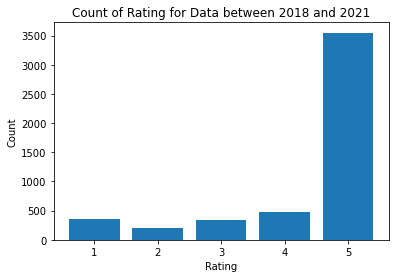

In [15]:
# Plot the count of different ratings for data between 2018 and 2021
tiktok_ios_ph_review_score_count = tiktok_ios_ph_review_YearMonth.groupby(['rating'])[['review']].nunique().rename(columns={'review':'count'})

plt.bar(tiktok_ios_ph_review_score_count.index,tiktok_ios_ph_review_score_count['count'])
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Count of Rating for Data between 2018 and 2021")
plt.show()

Text(0.5, 1.0, 'Count of Rating for Each Year between 2018 and 2021')

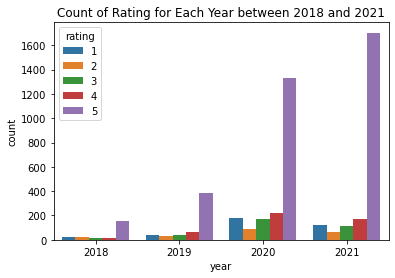

In [16]:
# Plot the count of different ratings for each year
tiktok_ios_ph_review_score_count_ByYear = (tiktok_ios_ph_review_YearMonth.groupby(['year','rating'])[['review']]
                                                                        .nunique()
                                                                        .rename(columns={'review':'count'})
                                                                        .reset_index()
                                              )

(sns.barplot(data=tiktok_ios_ph_review_score_count_ByYear,x='year',y='count',hue='rating')
   .set_title("Count of Rating for Each Year between 2018 and 2021")
)

# Comment: extreme review score on 1 or 5

In [17]:
# Understand average ratings over year
tiktok_ios_ph_review_avg_score_ByYear = (tiktok_ios_ph_review_YearMonth.groupby(['year'])[['rating']]
                                                                       .mean()
                                              )

tiktok_ios_ph_review_avg_score_ByYear['count'] = tiktok_ios_ph_review_score_count_ByYear.groupby('year')[['count']].sum().values

print('Average ratings and count of each year:')
tiktok_ios_ph_review_avg_score_ByYear

Average ratings and count of each year:


,rating,count
year,,
2018,4.131004,229
2019,4.275000,559
2020,4.233333,1995
2021,4.520218,2165


# Dataframe Preparation for Topic Modelling

In [18]:
# Dataframe with data between 2018 and 2021 without score or year filtering
tiktok_ios_ph_review_YearMonth.head()

,title,rating,isEdited,review,userName,date,developerResponse,year,month
0,Mine Is Lagging,3,False,Im Using Iphone 5 but still lagging so im just giving it 3 stars please fix it,Heyits_Aicknowz,2018-02-12,NaN,2018,2
1,Update it💙,5,False,I need a update! We need! \n\nA LIVE video which we can Communicate in our FANS and Friends in Tiktok\n\nI want Tiktok can Earn gift points from Fans! Pleasee update and make it Cool✨ \n\nGood🌵🌵,Asharry,2018-03-05,NaN,2018,3
2,Problem,4,False,"Its lagging and when i long press while filming, it randomnly stops while i’m filming even if im not letting go of the long press button. Please fix it. So far i like the app and the filters.😍",amandaB19,2018-03-11,NaN,2018,3
3,Note:,5,False,I absolutely love the app 🤭😩💖,Katrina Carmela,2018-03-15,NaN,2018,3
4,Changing Tiktok ID,1,False,I can’t change my ID It only allow 16 characters but the system need maximum 20 characters,armigos14,2018-04-09,NaN,2018,4


In [19]:
# Prepare dataframe for topic modelling for each score
# Obtain 5 dataframes with only score=1,2,3,4,5
tiktok_ios_ph_review_YearMonth_score1 = tiktok_ios_ph_review_YearMonth[tiktok_ios_ph_review_YearMonth['rating']==1]
tiktok_ios_ph_review_YearMonth_score2 = tiktok_ios_ph_review_YearMonth[tiktok_ios_ph_review_YearMonth['rating']==2]
tiktok_ios_ph_review_YearMonth_score3 = tiktok_ios_ph_review_YearMonth[tiktok_ios_ph_review_YearMonth['rating']==3]
tiktok_ios_ph_review_YearMonth_score4 = tiktok_ios_ph_review_YearMonth[tiktok_ios_ph_review_YearMonth['rating']==4]
tiktok_ios_ph_review_YearMonth_score5 = tiktok_ios_ph_review_YearMonth[tiktok_ios_ph_review_YearMonth['rating']==5]


In [20]:
# Prepare dataframe for grouped score
tiktok_ios_ph_review_YearMonth_score1N2N3 = tiktok_ios_ph_review_YearMonth[tiktok_ios_ph_review_YearMonth['rating'].isin([1,2,3])]
tiktok_ios_ph_review_YearMonth_score4N5 = tiktok_ios_ph_review_YearMonth[tiktok_ios_ph_review_YearMonth['rating'].isin([4,5])]


In [21]:
# Prepare dataframe for topic modelling for 2018,2019,2020,2021 for score = 1,2,3
tiktok_ios_ph_review_YearMonth_2018_score1N2N3 = tiktok_ios_ph_review_YearMonth[(tiktok_ios_ph_review_YearMonth['year']==2018)&(tiktok_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_ph_review_YearMonth_2019_score1N2N3 = tiktok_ios_ph_review_YearMonth[(tiktok_ios_ph_review_YearMonth['year']==2019)&(tiktok_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_ph_review_YearMonth_2020_score1N2N3 = tiktok_ios_ph_review_YearMonth[(tiktok_ios_ph_review_YearMonth['year']==2020)&(tiktok_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]
tiktok_ios_ph_review_YearMonth_2021_score1N2N3 = tiktok_ios_ph_review_YearMonth[(tiktok_ios_ph_review_YearMonth['year']==2021)&(tiktok_ios_ph_review_YearMonth['rating'].isin([1,2,3]))]




# Overall LDA Topic Modelling

In [22]:
# Overall Topic Modelling - data between 2018 and 2021 without score or year filtering
# Convert to list - move to each section
review_ph = tiktok_ios_ph_review_YearMonth.review.values.tolist()
review_words_ph = list(sent_to_words(review_ph))
print(review_words_ph[:1])

[['im', 'using', 'iphone', 'but', 'still', 'lagging', 'so', 'im', 'just', 'giving', 'it', 'stars', 'please', 'fix', 'it']]


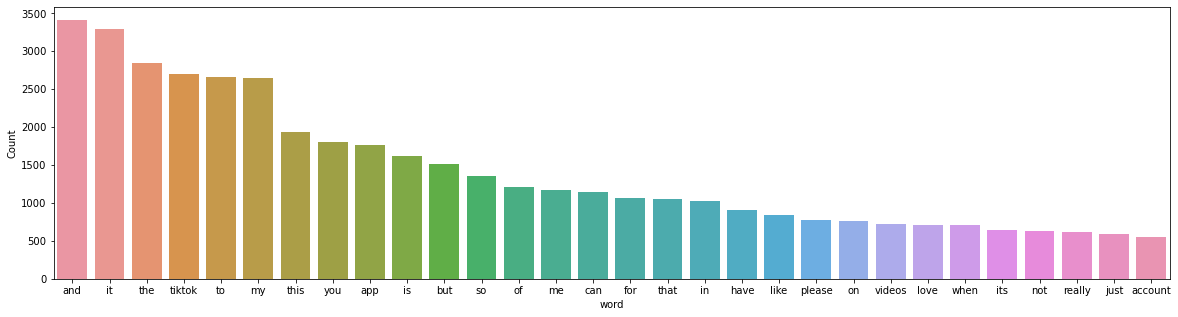

In [23]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph))

In [24]:
# Clean text
review_ph_ready = process_words(review_words_ph)  # processed Text Data! - move to each section

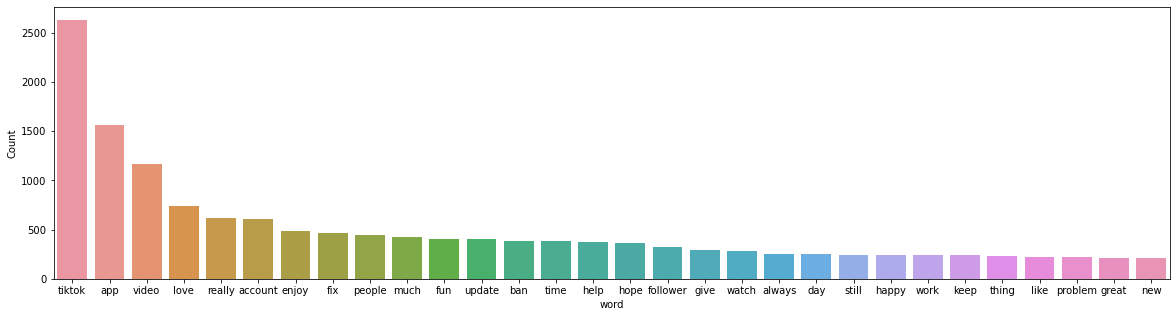

In [25]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready))

In [26]:
# Create Dictionary
id2word_ph = corpora.Dictionary(review_ph_ready)

In [27]:
# Create Corpus: Term Document Frequency
corpus_ph = [id2word_ph.doc2bow(text) for text in review_ph_ready]

In [28]:
# Training LDA model
model_list_ph, coherence_values_ph = compute_coherence_values(dictionary=id2word_ph, corpus=corpus_ph, 
                                                              texts=review_ph_ready, limit=30, start=2, step=5)

# Time Start: 03:44
# Time End: 
# Time Used: 

In [168]:
%store model_list_ph
%store coherence_values_ph

Stored 'model_list_ph' (list)
Stored 'coherence_values_ph' (list)


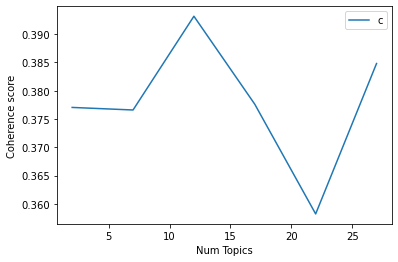

In [29]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3771
index: 1 | Num Topics = 7  has Coherence Value of 0.3766
index: 2 | Num Topics = 12  has Coherence Value of 0.3932
index: 3 | Num Topics = 17  has Coherence Value of 0.3776
index: 4 | Num Topics = 22  has Coherence Value of 0.3582
index: 5 | Num Topics = 27  has Coherence Value of 0.3848


In [164]:
# Select optimal number of topics
optimal_model_ph = model_list_ph[2]

In [165]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph = pyLDAvis.gensim_models.prepare(optimal_model_ph, corpus_ph, id2word_ph)

In [167]:
print("pyLDAVis for overall ph topics:")
vis_ph

pyLDAVis for overall ph topics:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.175245  0.071325       1        1  11.660784
8     -0.144273 -0.046841       2        1  11.637618
6     -0.182429  0.094294       3        1  11.195039
11    -0.080603 -0.087952       4        1  10.097967
4     -0.141037  0.046926       5        1   9.812521
9     -0.079317  0.148085       6        1   7.891070
1     -0.056505  0.196320       7        1   6.921345
7      0.265393  0.104930       8        1   6.728650
3      0.056661 -0.101782       9        1   6.497934
2      0.215584 -0.043042      10        1   6.308567
5     -0.054052 -0.216601      11        1   6.098066
10     0.025332 -0.165662      12        1   5.150439, topic_info=        Term         Freq        Total Category  logprob  loglift
17     video  1112.000000  1112.000000  Default  30.0000  30.0000
18       app  1441.000000  1441.000000  Default  29.0000  29.0000
30      love   685.000000   685.000000  Default  28.0000  28.0000
236    enjoy   467.000000   467.000000  Default  27.0000  27.0000
140  account   578.000000   578.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
1       give    29.437673   281.212071  Topic12  -4.3034   0.7093
18       app    29.387425  1441.072302  Topic12  -4.3052  -0.9265
257   become    16.051890    49.479838  Topic12  -4.9099   1.8403
543    power    13.546757    25.522150  Topic12  -5.0796   2.3327
432     life    13.844994   127.774719  Topic12  -5.0578   0.7437

[663 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
452       4  0.192317   able
452       5  0.598319   able
452       9  0.192317   able
1050      3  0.809534    acc
1050      4  0.179897    acc
...     ...       ...    ...
480       3  0.603808   year
480       4  0.207020   year
480      11  0.112136   year
215       2  0.977799  young
1363      6  0.928160     yr

[865 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 7, 12, 5, 10, 2, 8, 4, 3, 6, 11])

# By-rating LDA Topic Modelling

## LDA Topic Modelling (Rating = 1)

In [34]:
# By-rating Topic Modelling - rating = 1
# Convert to list - move to each section
review_ph_score1 = tiktok_ios_ph_review_YearMonth_score1.review.values.tolist()
review_words_ph_score1 = list(sent_to_words(review_ph_score1))
print(review_words_ph_score1[:1])

[['can', 'change', 'my', 'id', 'it', 'only', 'allow', 'characters', 'but', 'the', 'system', 'need', 'maximum', 'characters']]


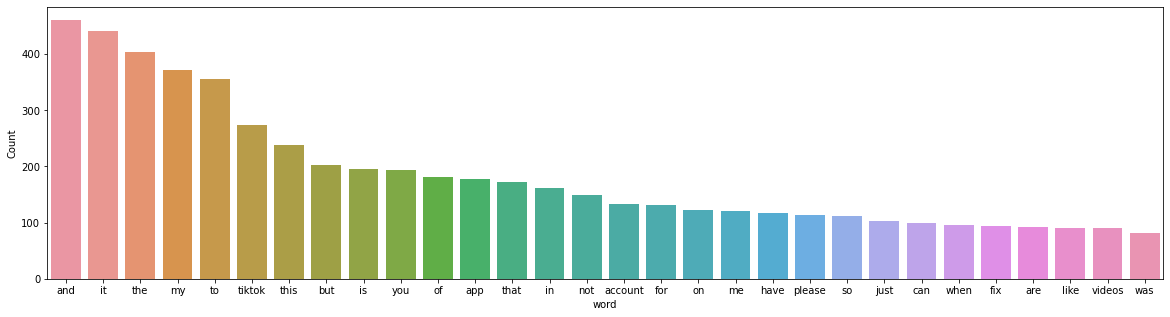

In [35]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1))

In [36]:
# Clean text
review_ph_ready_score1 = process_words(review_words_ph_score1)  # processed Text Data! - move to each section


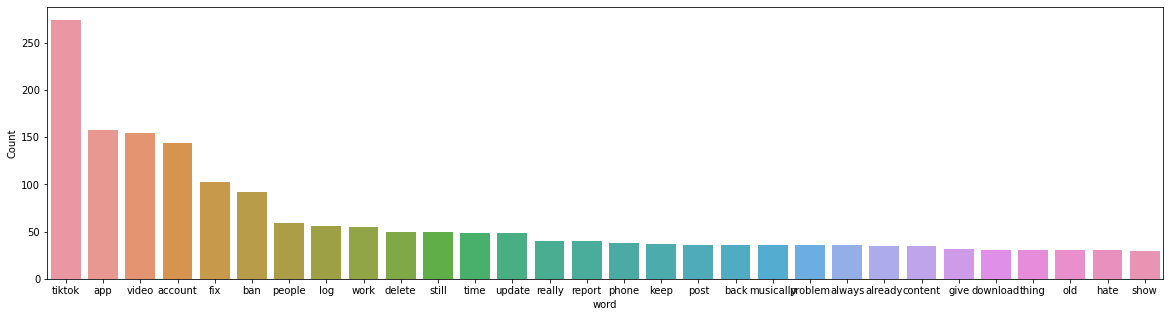

In [37]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1))


In [38]:
# Create Dictionary
id2word_ph_score1 = corpora.Dictionary(review_ph_ready_score1)

In [39]:
# Create Corpus: Term Document Frequency
corpus_ph_score1 = [id2word_ph_score1.doc2bow(text) for text in review_ph_ready_score1]

In [40]:
# Training LDA model
model_list_ph_score1, coherence_values_ph_score1 = compute_coherence_values(dictionary=id2word_ph_score1, corpus=corpus_ph_score1, 
                                                              texts=review_ph_ready_score1, limit=30, start=2, step=5)


In [41]:
%store model_list_ph_score1
%store coherence_values_ph_score1

Stored 'model_list_ph_score1' (list)
Stored 'coherence_values_ph_score1' (list)


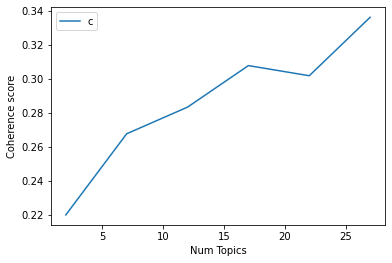

In [42]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [43]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 17

index: 0 | Num Topics = 2  has Coherence Value of 0.2201
index: 1 | Num Topics = 7  has Coherence Value of 0.2677
index: 2 | Num Topics = 12  has Coherence Value of 0.2834
index: 3 | Num Topics = 17  has Coherence Value of 0.3078
index: 4 | Num Topics = 22  has Coherence Value of 0.3019
index: 5 | Num Topics = 27  has Coherence Value of 0.3362


In [169]:
# Select optimal number of topics
optimal_model_ph_score1 = model_list_ph_score1[5]

In [170]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1, corpus_ph_score1, id2word_ph_score1)

In [171]:
print("pyLDAVis for ph topics for score=1:")
vis_ph_score1

pyLDAVis for ph topics for score=1:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.006029  0.092450       1        1  6.198891
3     -0.000335 -0.026194       2        1  6.011583
25     0.144891 -0.055417       3        1  5.741860
0      0.037747  0.133180       4        1  5.634551
21     0.199896 -0.025696       5        1  5.467379
7      0.063388 -0.029042       6        1  5.219167
19     0.062701 -0.046042       7        1  4.729231
17    -0.014944  0.029860       8        1  4.612955
18     0.021425 -0.142045       9        1  4.557113
10     0.052349  0.041235      10        1  4.430347
4      0.013146  0.099323      11        1  4.166296
23     0.017364 -0.003482      12        1  4.071660
9     -0.011053  0.184205      13        1  3.899504
1      0.106464  0.053974      14        1  3.657276
22    -0.053622 -0.046883      15        1  3.587413
6      0.033542 -0.067336      16        1  3.428802
11    -0.064808  0.027310      17        1  3.293091
16    -0.013292  0.037932      18        1  3.201182
8      0.067141 -0.091194      19        1  3.191931
2     -0.058209  0.005918      20        1  3.123591
20    -0.092938 -0.064478      21        1  2.970018
15    -0.108222  0.066423      22        1  2.262545
14     0.006176 -0.009673      23        1  2.150703
5     -0.121349 -0.052538      24        1  1.445081
24    -0.105802 -0.009998      25        1  1.265540
26    -0.116772 -0.082113      26        1  0.890186
13    -0.070912 -0.019681      27        1  0.792104, topic_info=           Term        Freq       Total Category  logprob  loglift
98      account  121.000000  121.000000  Default  30.0000  30.0000
94          log   47.000000   47.000000  Default  29.0000  29.0000
112   musically   31.000000   31.000000  Default  28.0000  28.0000
354         ban   78.000000   78.000000  Default  27.0000  27.0000
6           app  130.000000  130.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1075    concept    0.020871    1.382322  Topic27  -7.6667   0.6451
130       still    0.584371   42.360558  Topic27  -4.3345   0.5548
6           app    1.147884  130.155475  Topic27  -3.6594   0.1074
83          fix    0.584371   85.347237  Topic27  -4.3345  -0.1457
18       tiktok    0.584371  230.673695  Topic27  -4.3345  -1.1400

[1555 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
420      18  0.623104    abd
352       3  0.395280   able
352       5  0.197640   able
352      10  0.197640   able
352      11  0.197640   able
...     ...       ...    ...
167      19  0.171501    yet
82        2  0.110527  young
82        8  0.110527  young
82       17  0.442110  young
82       20  0.221055  young

[2682 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 4, 26, 1, 22, 8, 20, 18, 19, 11, 5, 24, 10, 2, 23, 7, 12, 17, 9, 3, 21, 16, 15, 6, 25, 27, 14])

## LDA Topic Modelling (Rating = 2)

In [47]:
# By-rating Topic Modelling - rating = 2
# Convert to list - move to each section
review_ph_score2 = tiktok_ios_ph_review_YearMonth_score2.review.values.tolist()
review_words_ph_score2 = list(sent_to_words(review_ph_score2))
print(review_words_ph_score2[:1])

[['dont', 'know', 'what', 'happened', 'it', 'was', 'working', 'just', 'fine', 'but', 'one', 'day', 'if', 'didnt', 'give', 'me', 'any', 'feeds', 'anymore', 'nor', 'lets', 'me', 'see', 'my', 'profile', 'its', 'blank', 'thought', 'it', 'was', 'my', 'internet', 'connection', 'whos', 'wrong', 'but', 'its', 'not', 'so', 'uninstalled', 'and', 'installed', 'it', 'again', 'few', 'times', 'already', 'even', 'rebooted', 'my', 'phone', 'over', 'and', 'over', 'again', 'up', 'to', 'now', 'still', 'cant', 'log', 'back', 'in', 'it', 'gives', 'me', 'the', 'option', 'to', 'link', 'my', 'facebook', 'acct', 'but', 'as', 'click', 'go', 'back', 'to', 'tik', 'tok', 'app', 'assuming', 'it', 'should', 'be', 'logging', 'me', 'in', 'already', 'but', 'its', 'not']]


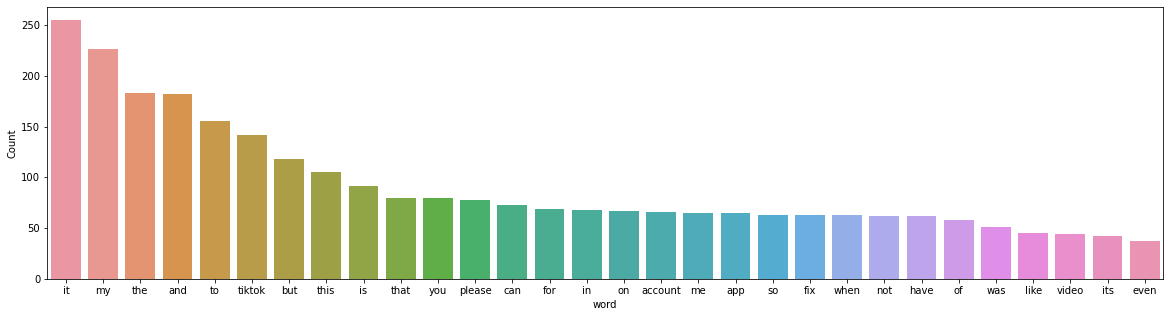

In [48]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score2))

In [49]:
# Clean text
review_ph_ready_score2 = process_words(review_words_ph_score2)  # processed Text Data! - move to each section


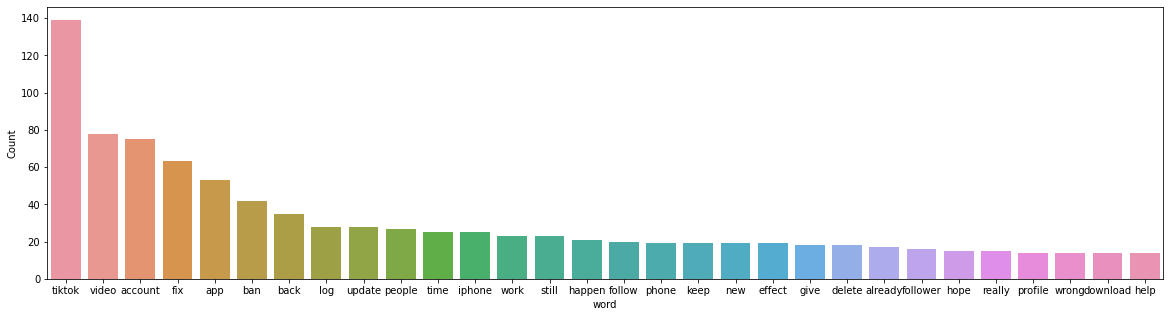

In [50]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score2))


In [51]:
# Create Dictionary
id2word_ph_score2 = corpora.Dictionary(review_ph_ready_score2)

In [52]:
# Create Corpus: Term Document Frequency
corpus_ph_score2 = [id2word_ph_score2.doc2bow(text) for text in review_ph_ready_score2]

In [53]:
# Training LDA model
model_list_ph_score2, coherence_values_ph_score2 = compute_coherence_values(dictionary=id2word_ph_score2, corpus=corpus_ph_score2, 
                                                              texts=review_ph_ready_score2, limit=30, start=2, step=5)


In [54]:
%store model_list_ph_score2
%store coherence_values_ph_score2

Stored 'model_list_ph_score2' (list)
Stored 'coherence_values_ph_score2' (list)


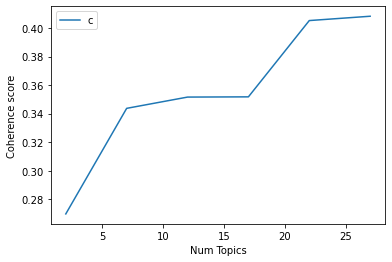

In [55]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [56]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score2):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 27

index: 0 | Num Topics = 2  has Coherence Value of 0.2697
index: 1 | Num Topics = 7  has Coherence Value of 0.3437
index: 2 | Num Topics = 12  has Coherence Value of 0.3516
index: 3 | Num Topics = 17  has Coherence Value of 0.3518
index: 4 | Num Topics = 22  has Coherence Value of 0.4052
index: 5 | Num Topics = 27  has Coherence Value of 0.4082


In [57]:
# Select optimal number of topics
optimal_model_ph_score2 = model_list_ph_score2[5]

In [58]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score2 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score2, corpus_ph_score2, id2word_ph_score2)

In [59]:
print("pyLDAVis for ph topics for score=2:")
vis_ph_score2

pyLDAVis for ph topics for score=2:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.122472 -0.095373       1        1  9.538031
19    -0.022809 -0.111928       2        1  7.710339
11     0.118132 -0.038368       3        1  6.448249
26     0.044346 -0.069060       4        1  5.669964
23    -0.089204 -0.096079       5        1  5.528439
7      0.080480 -0.114138       6        1  5.099240
10    -0.117845  0.121785       7        1  4.824007
16     0.073344 -0.012657       8        1  4.595109
8     -0.185437  0.023880       9        1  4.259898
15    -0.015691  0.063978      10        1  4.147279
25    -0.084489 -0.031455      11        1  3.799411
13     0.055732  0.002609      12        1  3.555841
18     0.007302 -0.064208      13        1  3.392432
12     0.104853 -0.069296      14        1  3.265625
1      0.072459  0.045655      15        1  3.165061
5      0.014964 -0.001512      16        1  3.039279
6     -0.030453 -0.020459      17        1  2.859372
24     0.081900  0.188883      18        1  2.804095
4     -0.124307  0.033589      19        1  2.744375
17    -0.001513 -0.019567      20        1  2.504903
14    -0.048231 -0.014351      21        1  2.291190
0      0.095300  0.084285      22        1  2.279133
22     0.065894 -0.043408      23        1  1.986125
3     -0.041158  0.103086      24        1  1.780687
2      0.039602  0.021564      25        1  1.212421
20     0.001460  0.046261      26        1  1.050894
21     0.027841  0.066283      27        1  0.448598, topic_info=        Term       Freq      Total Category  logprob  loglift
63   account  61.000000  61.000000  Default  30.0000  30.0000
100   effect  14.000000  14.000000  Default  29.0000  29.0000
19       log  22.000000  22.000000  Default  28.0000  28.0000
36     video  63.000000  63.000000  Default  27.0000  27.0000
456      ban  34.000000  34.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
19       log   0.013277  22.621860  Topic27  -6.7935  -2.0338
20    option   0.013277   7.787371  Topic27  -6.7935  -0.9674
21     phone   0.013277  15.879668  Topic27  -6.7935  -1.6800
22   profile   0.013277  12.227115  Topic27  -6.7935  -1.4186
23    reboot   0.013277   1.561649  Topic27  -6.7935   0.6393

[1294 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
244       1  0.159707       acc
244       7  0.319415       acc
244       9  0.319415       acc
244      25  0.159707       acc
703      12  0.665185    accept
...     ...       ...       ...
407      12  0.208428       yet
589       1  0.886116  youtuber
691       7  0.634705     yrold
390       7  0.831077        yt
331      14  0.662125      zoom

[1594 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 20, 12, 27, 24, 8, 11, 17, 9, 16, 26, 14, 19, 13, 2, 6, 7, 25, 5, 18, 15, 1, 23, 4, 3, 21, 22])

## LDA Topic Modelling (Rating = 3)

In [60]:
# By-rating Topic Modelling - rating = 3
# Convert to list - move to each section
review_ph_score3 = tiktok_ios_ph_review_YearMonth_score3.review.values.tolist()
review_words_ph_score3 = list(sent_to_words(review_ph_score3))
print(review_words_ph_score3[:1])

[['im', 'using', 'iphone', 'but', 'still', 'lagging', 'so', 'im', 'just', 'giving', 'it', 'stars', 'please', 'fix', 'it']]


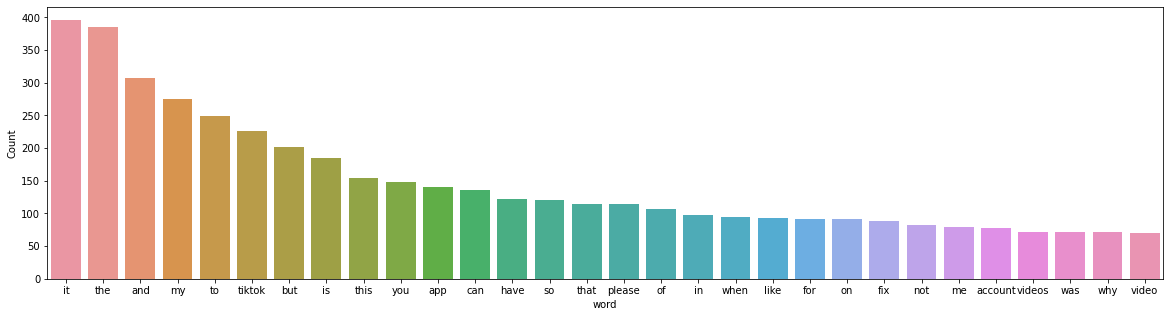

In [61]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score3))

In [62]:
# Clean text
review_ph_ready_score3 = process_words(review_words_ph_score3)  # processed Text Data! - move to each section


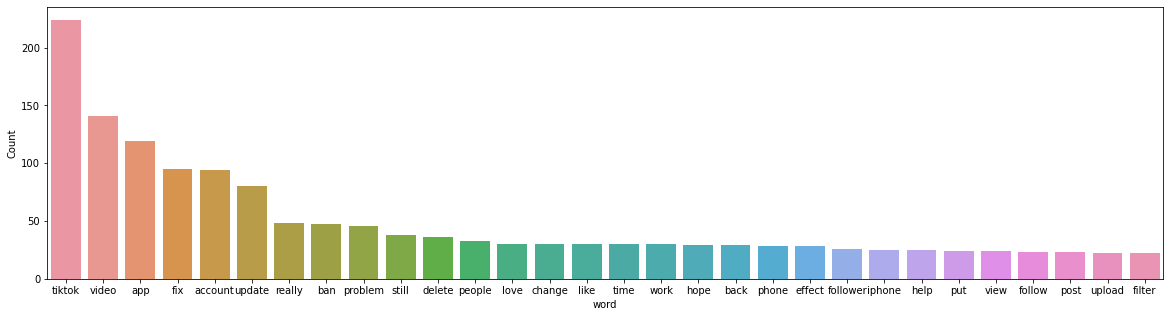

In [63]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score3))


In [64]:
# Create Dictionary
id2word_ph_score3 = corpora.Dictionary(review_ph_ready_score3)

In [65]:
# Create Corpus: Term Document Frequency
corpus_ph_score3 = [id2word_ph_score3.doc2bow(text) for text in review_ph_ready_score3]

In [66]:
# Training LDA model
model_list_ph_score3, coherence_values_ph_score3 = compute_coherence_values(dictionary=id2word_ph_score3, corpus=corpus_ph_score3, 
                                                              texts=review_ph_ready_score3, limit=30, start=2, step=5)


In [67]:
%store model_list_ph_score3
%store coherence_values_ph_score3

Stored 'model_list_ph_score3' (list)
Stored 'coherence_values_ph_score3' (list)


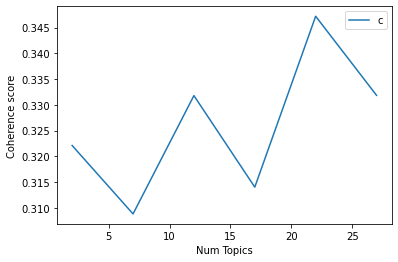

In [68]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [69]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3221
index: 1 | Num Topics = 7  has Coherence Value of 0.3088
index: 2 | Num Topics = 12  has Coherence Value of 0.3318
index: 3 | Num Topics = 17  has Coherence Value of 0.314
index: 4 | Num Topics = 22  has Coherence Value of 0.3472
index: 5 | Num Topics = 27  has Coherence Value of 0.3318


In [172]:
# Select optimal number of topics
optimal_model_ph_score3 = model_list_ph_score3[4]

In [173]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score3, corpus_ph_score3, id2word_ph_score3)

In [174]:
print("pyLDAVis for ph topics for score=3:")
vis_ph_score3

pyLDAVis for ph topics for score=3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.063263 -0.112617       1        1  10.829414
10     0.098104  0.169629       2        1   8.606428
9      0.041062 -0.017342       3        1   7.429221
2      0.105424  0.056728       4        1   7.397384
19     0.116298  0.011085       5        1   6.995411
18     0.041514 -0.051783       6        1   6.958234
7      0.090933  0.057035       7        1   5.945727
11    -0.017637 -0.084082       8        1   4.957359
16     0.055117 -0.038116       9        1   4.906524
15     0.052550 -0.072669      10        1   4.554983
8      0.046188  0.021051      11        1   4.481057
14    -0.015866 -0.015733      12        1   4.321881
12    -0.030733 -0.015595      13        1   3.734283
13    -0.012402 -0.130781      14        1   3.616793
1      0.040139  0.060150      15        1   3.598510
21    -0.047089 -0.021992      16        1   2.848549
0     -0.052687 -0.054827      17        1   2.318836
3     -0.135345 -0.027246      18        1   2.159077
20    -0.073493  0.092058      19        1   1.443668
4     -0.117709  0.069187      20        1   1.094258
5     -0.104959  0.052740      21        1   1.067251
17    -0.142670  0.053119      22        1   0.735151, topic_info=       Term       Freq      Total Category  logprob  loglift
15   update  66.000000  66.000000  Default  30.0000  30.0000
164     ban  40.000000  40.000000  Default  29.0000  29.0000
324    live  17.000000  17.000000  Default  28.0000  28.0000
7       app  98.000000  98.000000  Default  27.0000  27.0000
118    like  25.000000  25.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
2    iphone   0.022272  21.391193  Topic22  -7.2171  -1.9546
3       lag   0.022272  13.467372  Topic22  -7.2171  -1.4918
4      star   0.022272  13.744981  Topic22  -7.2171  -1.5123
7       app   0.022272  98.645648  Topic22  -7.2171  -3.4831
8      hope   0.022272  24.329000  Topic22  -7.2171  -2.0832

[1221 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
761      18  0.672052  ability
256       1  0.304956     able
256       3  0.152478     able
256       9  0.152478     able
256      15  0.152478     able
...     ...       ...      ...
233      13  0.200974     year
515       1  0.322286      yet
515      17  0.322286      yet
686       5  0.808608    young
223       3  0.611168     zoom

[1815 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 11, 10, 3, 20, 19, 8, 12, 17, 16, 9, 15, 13, 14, 2, 22, 1, 4, 21, 5, 6, 18])

## LDA Topic Modelling (Rating = 4)

In [73]:
# By-rating Topic Modelling - rating = 4
# Convert to list - move to each section
review_ph_score4 = tiktok_ios_ph_review_YearMonth_score4.review.values.tolist()
review_words_ph_score4 = list(sent_to_words(review_ph_score4))
print(review_words_ph_score4[2:3])

[['pls', 'add', 'more', 'kpop', 'songs', 'there', 'are', 'more', 'kpopers', 'than', 'west', 'poppers']]


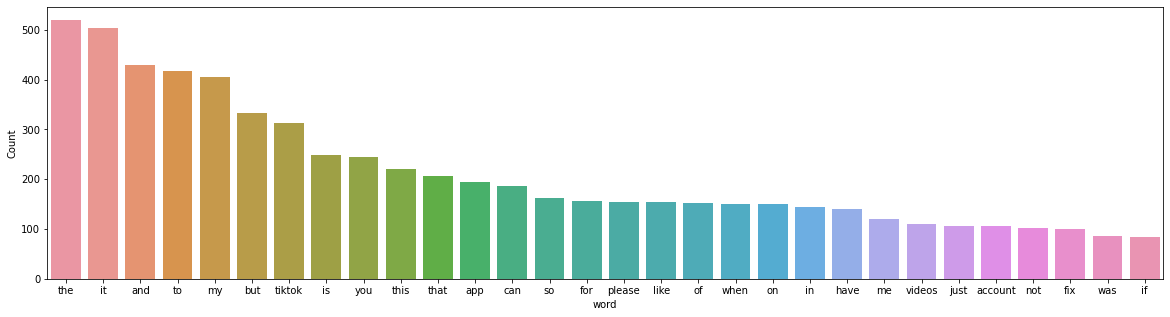

In [74]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score4))

In [75]:
# Clean text
review_ph_ready_score4 = process_words(review_words_ph_score4)  # processed Text Data! - move to each section

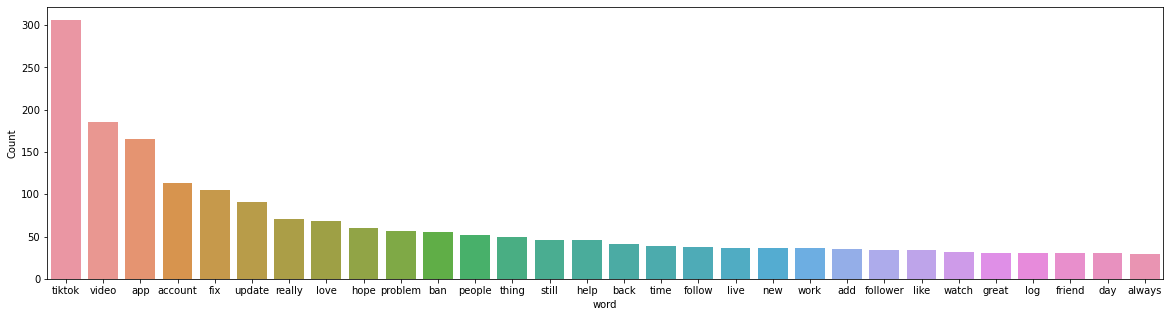

In [76]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score4))


In [77]:
# Create Dictionary
id2word_ph_score4 = corpora.Dictionary(review_ph_ready_score4)

In [78]:
# Create Corpus: Term Document Frequency
corpus_ph_score4 = [id2word_ph_score4.doc2bow(text) for text in review_ph_ready_score4]

In [79]:
# Training LDA model
model_list_ph_score4, coherence_values_ph_score4 = compute_coherence_values(dictionary=id2word_ph_score4, corpus=corpus_ph_score4, 
                                                              texts=review_ph_ready_score4, limit=30, start=2, step=5)


In [80]:
%store model_list_ph_score4
%store coherence_values_ph_score4

Stored 'model_list_ph_score4' (list)
Stored 'coherence_values_ph_score4' (list)


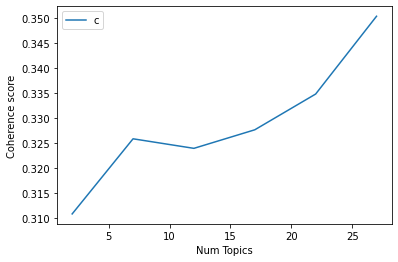

In [81]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score4)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [82]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score4):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics =  27

index: 0 | Num Topics = 2  has Coherence Value of 0.3108
index: 1 | Num Topics = 7  has Coherence Value of 0.3258
index: 2 | Num Topics = 12  has Coherence Value of 0.3239
index: 3 | Num Topics = 17  has Coherence Value of 0.3276
index: 4 | Num Topics = 22  has Coherence Value of 0.3348
index: 5 | Num Topics = 27  has Coherence Value of 0.3504


In [175]:
# Select optimal number of topics
optimal_model_ph_score4 = model_list_ph_score4[5]

In [176]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score4 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score4, corpus_ph_score4, id2word_ph_score4)

In [177]:
print("pyLDAVis for ph topics for score=4:")
vis_ph_score4

pyLDAVis for ph topics for score=4:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
20    -0.033352 -0.077878       1        1  8.065389
25    -0.063588  0.025530       2        1  6.007672
14    -0.045417 -0.047786       3        1  5.796121
17    -0.171059  0.009709       4        1  5.605401
16    -0.075337  0.051907       5        1  5.384352
26    -0.064917 -0.014473       6        1  5.362695
24     0.005254 -0.048352       7        1  4.942801
6     -0.001539 -0.060105       8        1  4.731819
13    -0.095867  0.081034       9        1  4.520596
4     -0.052482  0.189924      10        1  4.273441
23    -0.089390 -0.070021      11        1  4.268056
21    -0.013329 -0.061951      12        1  3.985069
10     0.002374  0.072897      13        1  3.703931
18    -0.041226  0.006390      14        1  3.620129
15     0.024872 -0.141725      15        1  3.516428
1     -0.009855  0.003100      16        1  3.107185
8      0.001273 -0.015528      17        1  2.908809
3      0.077142  0.045209      18        1  2.735101
0     -0.043894 -0.026367      19        1  2.697581
19     0.044783 -0.093667      20        1  2.464964
12     0.106682  0.108813      21        1  2.394986
11     0.031910 -0.024462      22        1  2.212940
9      0.053509  0.055671      23        1  2.211906
2      0.112976  0.054763      24        1  1.894410
22     0.078204  0.029235      25        1  1.731473
5      0.147553 -0.024800      26        1  0.985037
7      0.114721 -0.027066      27        1  0.871708, topic_info=        Term        Freq       Total Category  logprob  loglift
84   account   96.000000   96.000000  Default  30.0000  30.0000
137   follow   32.000000   32.000000  Default  29.0000  29.0000
180     help   39.000000   39.000000  Default  28.0000  28.0000
0        app  137.000000  137.000000  Default  27.0000  27.0000
328     mode   24.000000   24.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
0        app    1.835191  137.898579  Topic27  -3.3456   0.4231
6        fix    0.626642   88.650508  Topic27  -4.4201  -0.2096
260     time    0.626642   33.154491  Topic27  -4.4201   0.7739
38    tiktok    0.626642  259.029993  Topic27  -4.4201  -1.2819
208      ban    0.626641   46.758163  Topic27  -4.4201   0.4301

[1583 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
951      16  0.616553    abble
1156     21  0.632854  ability
107       5  0.266018     able
107       7  0.133009     able
107      10  0.133009     able
...     ...       ...      ...
656       6  0.600876      𝓪𝓷𝓭
657       6  0.600876      𝓱𝓪𝓭
660       6  0.793420    𝓽𝓲𝓶𝓮𝓼
661       6  0.600876       𝔀𝓮
662       6  0.600876      𝔂𝓸𝓾

[2646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[21, 26, 15, 18, 17, 27, 25, 7, 14, 5, 24, 22, 11, 19, 16, 2, 9, 4, 1, 20, 13, 12, 10, 3, 23, 6, 8])

## LDA Topic Modelling (Rating = 5)

In [86]:
# By-rating Topic Modelling - rating = 5
# Convert to list - move to each section
review_ph_score5 = tiktok_ios_ph_review_YearMonth_score5.review.values.tolist()
review_words_ph_score5 = list(sent_to_words(review_ph_score5))
print(review_words_ph_score5[:1])

[['need', 'update', 'we', 'need', 'live', 'video', 'which', 'we', 'can', 'communicate', 'in', 'our', 'fans', 'and', 'friends', 'in', 'tiktok', 'want', 'tiktok', 'can', 'earn', 'gift', 'points', 'from', 'fans', 'pleasee', 'update', 'and', 'make', 'it', 'cool', 'good']]


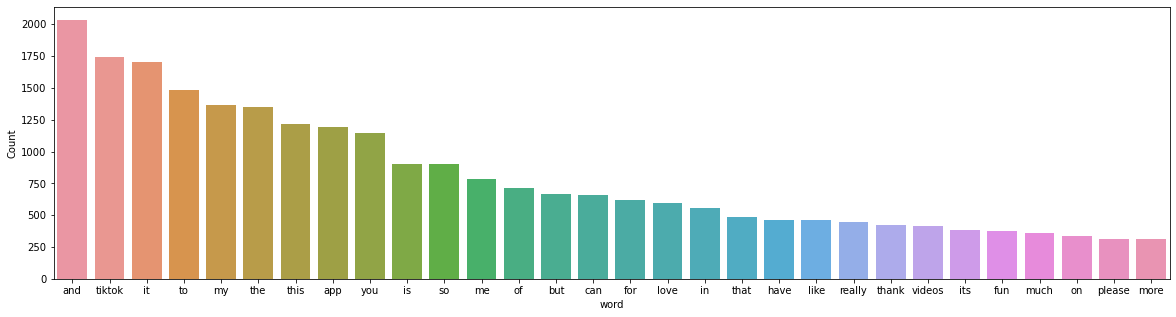

In [87]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score5))

In [88]:
# Clean text
review_ph_ready_score5 = process_words(review_words_ph_score5)  # processed Text Data! - move to each section

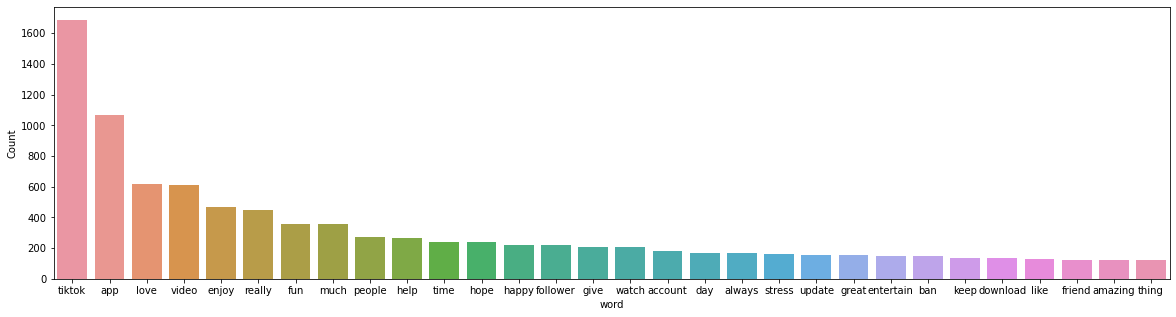

In [89]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score5))


In [90]:
# Create Dictionary
id2word_ph_score5 = corpora.Dictionary(review_ph_ready_score5)

In [91]:
# Create Corpus: Term Document Frequency
corpus_ph_score5 = [id2word_ph_score5.doc2bow(text) for text in review_ph_ready_score5]

In [92]:
# Training LDA model
model_list_ph_score5, coherence_values_ph_score5 = compute_coherence_values(dictionary=id2word_ph_score5, corpus=corpus_ph_score5, 
                                                              texts=review_ph_ready_score5, limit=30, start=2, step=5)


In [93]:
%store model_list_ph_score5
%store coherence_values_ph_score5

Stored 'model_list_ph_score5' (list)
Stored 'coherence_values_ph_score5' (list)


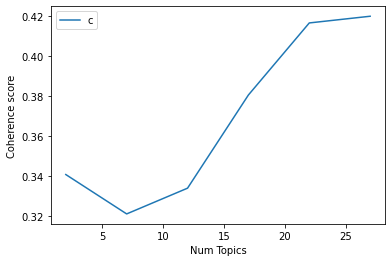

In [94]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score5)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [95]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score5):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3407
index: 1 | Num Topics = 7  has Coherence Value of 0.321
index: 2 | Num Topics = 12  has Coherence Value of 0.3339
index: 3 | Num Topics = 17  has Coherence Value of 0.3805
index: 4 | Num Topics = 22  has Coherence Value of 0.4165
index: 5 | Num Topics = 27  has Coherence Value of 0.4199


In [178]:
# Select optimal number of topics
optimal_model_ph_score5 = model_list_ph_score5[4]

In [179]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score5 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score5, corpus_ph_score5, id2word_ph_score5)

In [180]:
print("pyLDAVis for ph topics for score=5:")
vis_ph_score5

pyLDAVis for ph topics for score=5:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
2     -0.186526  0.024925       1        1  6.854007
16     0.028461 -0.085683       2        1  6.656126
18     0.053144 -0.155460       3        1  6.553539
4     -0.238253  0.008882       4        1  6.419911
5     -0.196863  0.111166       5        1  6.162846
19    -0.132849 -0.082275       6        1  5.398287
1      0.081170 -0.115226       7        1  5.379247
6     -0.180368  0.204998       8        1  5.237164
21    -0.000456 -0.249073       9        1  5.061767
14    -0.007276 -0.077298      10        1  4.656790
10     0.076986  0.012958      11        1  4.375710
3      0.028992 -0.026751      12        1  4.292829
7      0.031883 -0.094502      13        1  4.241423
0     -0.003462  0.004599      14        1  3.769364
17    -0.031558 -0.009898      15        1  3.615843
20    -0.003607 -0.028778      16        1  3.468469
12     0.069143  0.159776      17        1  3.443694
8      0.048602 -0.051598      18        1  3.276043
13     0.220430  0.103509      19        1  2.985310
11     0.119288  0.170195      20        1  2.973750
9      0.043057  0.049652      21        1  2.902910
15     0.180063  0.125882      22        1  2.274972, topic_info=       Term        Freq        Total Category  logprob  loglift
14     love  570.000000   570.000000  Default  30.0000  30.0000
35   really  412.000000   412.000000  Default  29.0000  29.0000
130    much  336.000000   336.000000  Default  28.0000  28.0000
11    video  601.000000   601.000000  Default  27.0000  27.0000
80     time  260.000000   260.000000  Default  26.0000  26.0000
..      ...         ...          ...      ...      ...      ...
724     bit    9.384981    15.906332  Topic22  -4.0593   3.2556
549   email    5.554606    10.291341  Topic22  -4.5838   3.1665
10   update   22.547831   155.730760  Topic22  -3.1828   1.8507
118  change    4.889561    50.396370  Topic22  -4.7113   1.4504
13      app    5.213163  1018.639224  Topic22  -4.6472  -1.4918

[903 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
261      17  0.955490        able
12       14  0.734516  absolutely
863       3  0.917008         acc
797       3  0.563294      access
797      20  0.375529      access
...     ...       ...         ...
40       14  0.838128         yah
614       3  0.984690        year
584      15  0.927895         yet
716      19  0.877567       young
961       2  0.859332          yr

[1026 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 17, 19, 5, 6, 20, 2, 7, 22, 15, 11, 4, 8, 1, 18, 21, 13, 9, 14, 12, 10, 16])

## LDA Topic Modelling (Rating = 1,2,3)

In [99]:
# By-rating Topic Modelling - rating = 1,2,3
# Convert to list - move to each section
review_ph_score1N2N3 = tiktok_ios_ph_review_YearMonth_score1N2N3.review.values.tolist()
review_words_ph_score1N2N3 = list(sent_to_words(review_ph_score1N2N3))
print(review_words_ph_score1N2N3[:1])

[['im', 'using', 'iphone', 'but', 'still', 'lagging', 'so', 'im', 'just', 'giving', 'it', 'stars', 'please', 'fix', 'it']]


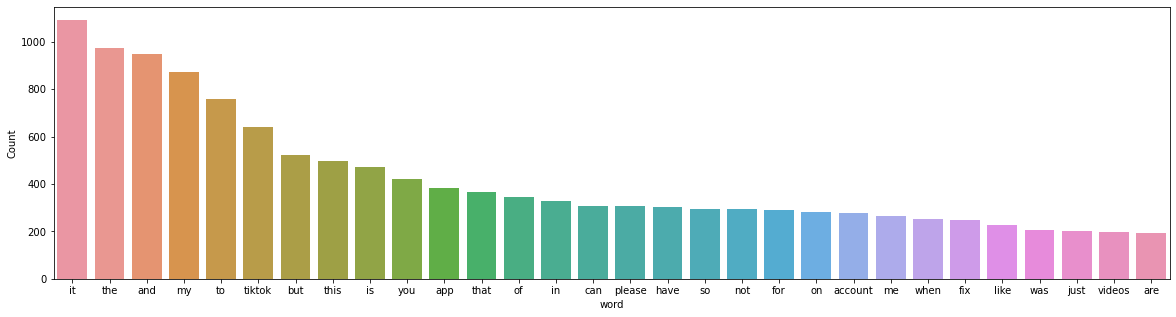

In [100]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_score1N2N3))

In [101]:
# Clean text
review_ph_ready_score1N2N3 = process_words(review_words_ph_score1N2N3)  # processed Text Data! - move to each section

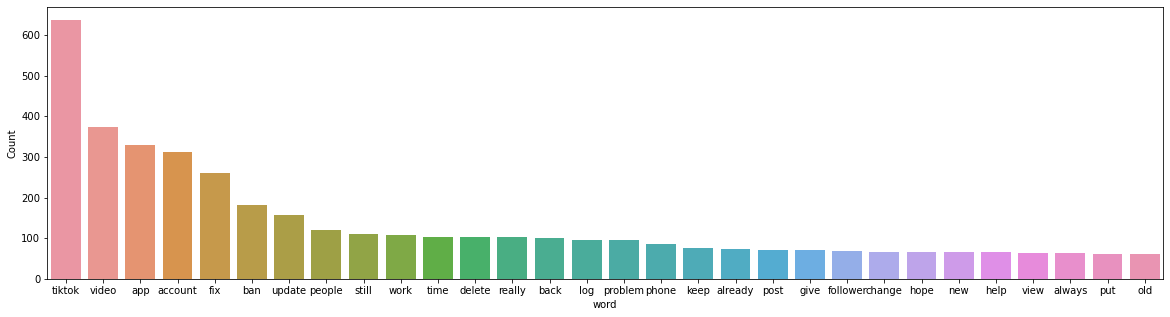

In [102]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_ph_ready_score1N2N3))


In [103]:
# Create Dictionary
id2word_ph_score1N2N3 = corpora.Dictionary(review_ph_ready_score1N2N3)

In [104]:
# Create Corpus: Term Document Frequency
corpus_ph_score1N2N3 = [id2word_ph_score1N2N3.doc2bow(text) for text in review_ph_ready_score1N2N3]

In [105]:
# Training LDA model
model_list_ph_score1N2N3, coherence_values_ph_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_score1N2N3, corpus=corpus_ph_score1N2N3, 
                                                              texts=review_ph_ready_score1N2N3, limit=30, start=2, step=5)


In [106]:
%store model_list_ph_score1N2N3
%store coherence_values_ph_score1N2N3

Stored 'model_list_ph_score1N2N3' (list)
Stored 'coherence_values_ph_score1N2N3' (list)


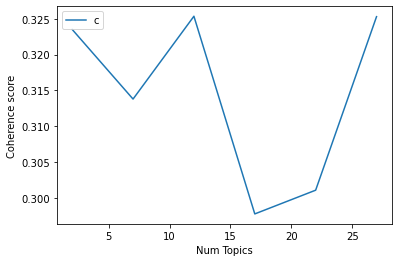

In [107]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [108]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 12

index: 0 | Num Topics = 2  has Coherence Value of 0.3235
index: 1 | Num Topics = 7  has Coherence Value of 0.3138
index: 2 | Num Topics = 12  has Coherence Value of 0.3253
index: 3 | Num Topics = 17  has Coherence Value of 0.2977
index: 4 | Num Topics = 22  has Coherence Value of 0.3011
index: 5 | Num Topics = 27  has Coherence Value of 0.3253


In [181]:
# Select optimal number of topics
optimal_model_ph_score1N2N3 = model_list_ph_score1N2N3[2]

In [182]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_score1N2N3, corpus_ph_score1N2N3, id2word_ph_score1N2N3)

In [183]:
print("pyLDAVis for ph topics for score=1,2,3:")
vis_ph_score1N2N3

pyLDAVis for ph topics for score=1,2,3:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.034160  0.101130       1        1  12.532085
6      0.013226 -0.000801       2        1  11.082994
2     -0.008157  0.071750       3        1  10.327324
0     -0.046553 -0.070413       4        1  10.088146
7      0.072220  0.035532       5        1  10.041755
11    -0.031655 -0.147526       6        1   9.693207
8      0.019838  0.002706       7        1   8.906074
5     -0.250979 -0.004839       8        1   8.465461
3      0.009604  0.023347       9        1   6.464223
4      0.063433  0.141786      10        1   5.782562
1      0.065627 -0.040765      11        1   3.579426
9      0.127555 -0.111907      12        1   3.036742, topic_info=           Term        Freq       Total Category  logprob  loglift
182     account  278.000000  278.000000  Default  30.0000  30.0000
50          log   84.000000   84.000000  Default  29.0000  29.0000
408         ban  160.000000  160.000000  Default  28.0000  28.0000
285        live   42.000000   42.000000  Default  27.0000  27.0000
108      effect   54.000000   54.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
14         love    2.852937   47.106310  Topic12  -4.8824   0.6903
504  understand    2.170771   13.720972  Topic12  -5.1557   1.6505
25     download    2.655892   54.024643  Topic12  -4.9540   0.4817
1          give    2.631216   61.831996  Topic12  -4.9633   0.3374
22        video    2.365793  327.699440  Topic12  -5.0696  -1.4366

[797 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1036      9  0.581754  absolutely
510       1  0.049398         acc
510       3  0.148195         acc
510       5  0.148195         acc
510       6  0.049398         acc
...     ...       ...         ...
152       2  0.087242       young
152       5  0.610697       young
152       9  0.261727       young
1422      1  0.844641    youtuber
882       8  0.764749          yt

[1649 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 7, 3, 1, 8, 12, 9, 6, 4, 5, 2, 10])

# By-rating of each year

## By-rating of 2018 (Rating=1,2,3)

In [112]:
# By-rating Topic Modelling - rating = 1,2,3 in 2018
# Convert to list - move to each section
review_ph_2018_score1N2N3 = tiktok_ios_ph_review_YearMonth_2018_score1N2N3.review.values.tolist()
review_words_ph_2018_score1N2N3 = list(sent_to_words(review_ph_2018_score1N2N3))
print(review_words_ph_2018_score1N2N3[:1])

[['im', 'using', 'iphone', 'but', 'still', 'lagging', 'so', 'im', 'just', 'giving', 'it', 'stars', 'please', 'fix', 'it']]


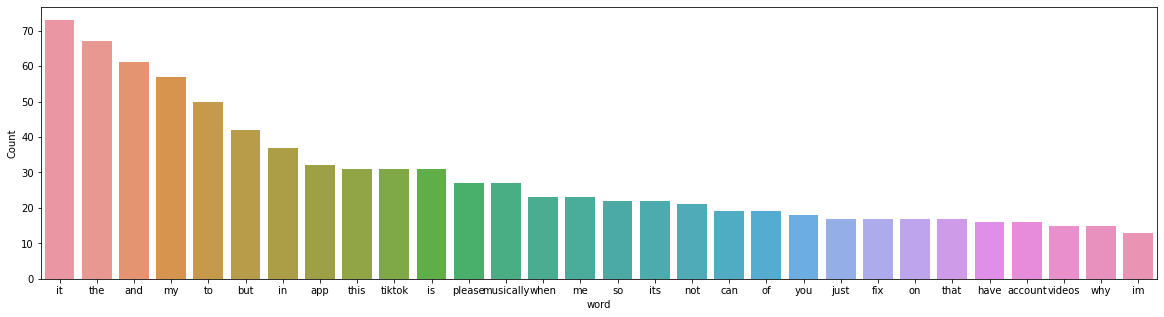

In [113]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2018_score1N2N3))

In [114]:
# Clean text
review_words_ph_ready_2018_score1N2N3 = process_words(review_words_ph_2018_score1N2N3)  # processed Text Data! - move to each section

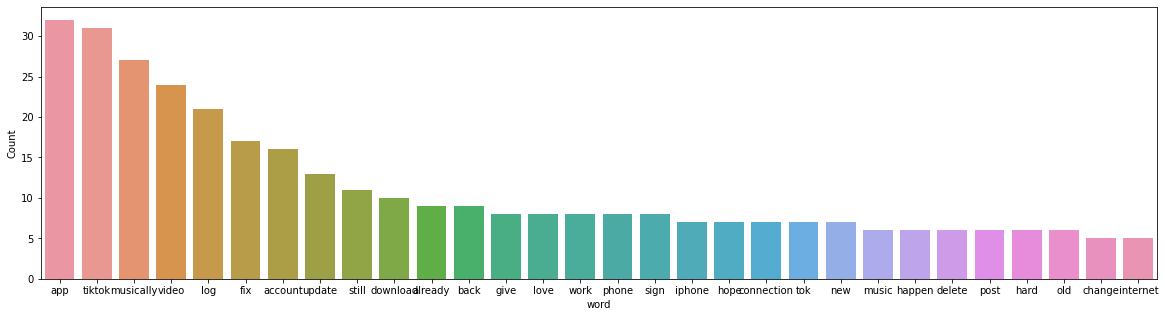

In [115]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2018_score1N2N3))


In [116]:
# Create Dictionary
id2word_ph_2018_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2018_score1N2N3)

In [117]:
# Create Corpus: Term Document Frequency
corpus_ph_2018_score1N2N3 = [id2word_ph_2018_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2018_score1N2N3]

In [118]:
# Training LDA model
model_list_ph_2018_score1N2N3, coherence_values_ph_2018_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2018_score1N2N3, corpus=corpus_ph_2018_score1N2N3, 
                                                              texts=review_words_ph_ready_2018_score1N2N3, limit=30, start=2, step=5)


In [119]:
%store model_list_ph_2018_score1N2N3
%store coherence_values_ph_2018_score1N2N3

Stored 'model_list_ph_2018_score1N2N3' (list)
Stored 'coherence_values_ph_2018_score1N2N3' (list)


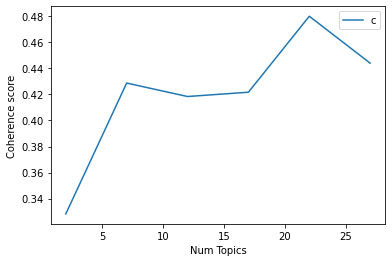

In [120]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2018_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [121]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2018_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 2

index: 0 | Num Topics = 2  has Coherence Value of 0.3282
index: 1 | Num Topics = 7  has Coherence Value of 0.4287
index: 2 | Num Topics = 12  has Coherence Value of 0.4184
index: 3 | Num Topics = 17  has Coherence Value of 0.4217
index: 4 | Num Topics = 22  has Coherence Value of 0.48
index: 5 | Num Topics = 27  has Coherence Value of 0.444


In [184]:
# Select optimal number of topics
optimal_model_ph_2018_score1N2N3 = model_list_ph_2018_score1N2N3[4]

In [185]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2018_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2018_score1N2N3, corpus_ph_2018_score1N2N3, id2word_ph_2018_score1N2N3)

In [186]:
print("pyLDAVis for ph topics for score=1,2,3 in 2018:")
vis_ph_2018_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2018:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
21     0.220655 -0.010339       1        1  12.837454
10    -0.151521  0.041130       2        1   9.878178
0     -0.150349 -0.129935       3        1   9.666566
15    -0.059990 -0.221615       4        1   9.234136
17    -0.156207  0.108575       5        1   9.022309
19     0.011005  0.155519       6        1   7.580758
8     -0.071694  0.063081       7        1   6.726924
16    -0.059742  0.039335       8        1   4.956536
5     -0.079667 -0.066060       9        1   4.685966
2     -0.027098  0.109620      10        1   3.913113
4      0.118140  0.004516      11        1   3.548503
12    -0.045835 -0.009485      12        1   3.270463
3     -0.029778  0.043697      13        1   2.760653
1     -0.010449 -0.053217      14        1   2.487959
6      0.066739  0.047330      15        1   2.126101
11     0.092442 -0.015992      16        1   1.720859
18     0.077247 -0.058492      17        1   1.593312
14     0.007504 -0.026031      18        1   1.465915
7      0.049478  0.022238      19        1   1.338712
13     0.084552 -0.009715      20        1   0.587750
9      0.057285 -0.017080      21        1   0.298918
20     0.057285 -0.017081      22        1   0.298918, topic_info=         Term       Freq      Total Category  logprob  loglift
31     tiktok  23.000000  23.000000  Default  30.0000  30.0000
50        log  16.000000  16.000000  Default  29.0000  29.0000
16  musically  21.000000  21.000000  Default  28.0000  28.0000
22      video  18.000000  18.000000  Default  27.0000  27.0000
12        app  24.000000  24.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
21     upload   0.007487   3.693043  Topic22  -5.7398  -0.3882
22      video   0.007487  18.604357  Topic22  -5.7398  -2.0052
23        way   0.007487   3.013964  Topic22  -5.7398  -0.1850
24        beg   0.007487   1.873481  Topic22  -5.7398   0.2904
25   download   0.007487   7.946206  Topic22  -5.7398  -1.1545

[1007 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
182       2  0.375699  account
182       3  0.300559  account
182       4  0.150280  account
182       7  0.075140  account
182       8  0.075140  account
...     ...       ...      ...
61       16  0.515591    wrong
253       4  0.700959      wth
256       5  0.710284     year
257       5  0.710284      yet
152       1  0.926338    young

[532 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 11, 1, 16, 18, 20, 9, 17, 6, 3, 5, 13, 4, 2, 7, 12, 19, 15, 8, 14, 10, 21])

## By-rating of 2019 (Rating=1,2,3)

In [125]:
# By-rating Topic Modelling - rating = 1,2,3 in 2019
# Convert to list - move to each section
review_ph_2019_score1N2N3 = tiktok_ios_ph_review_YearMonth_2019_score1N2N3.review.values.tolist()
review_words_ph_2019_score1N2N3 = list(sent_to_words(review_ph_2019_score1N2N3))
print(review_words_ph_2019_score1N2N3[:1])

[['hey', 'tik', 'tok', 'would', 'like', 'to', 'say', 'that', 'my', 'account', 'is', 'broken', 'or', 'lagging', 'or', 'glitching', 'cause', 'it', 'won', 'let', 'me', 'follow', 'my', 'friends', 'please', 'do', 'everything', 'and', 'also', 'it', 'always', 'says', 'slow', 'down', 'your', 'following', 'to', 'fast', 'but', 'im', 'not', 'im', 'following', 'every', 'single', 'followers', 'and', 'yeah', 'hopefully', 'remove', 'the', 'glitches', 'or', 'anything']]


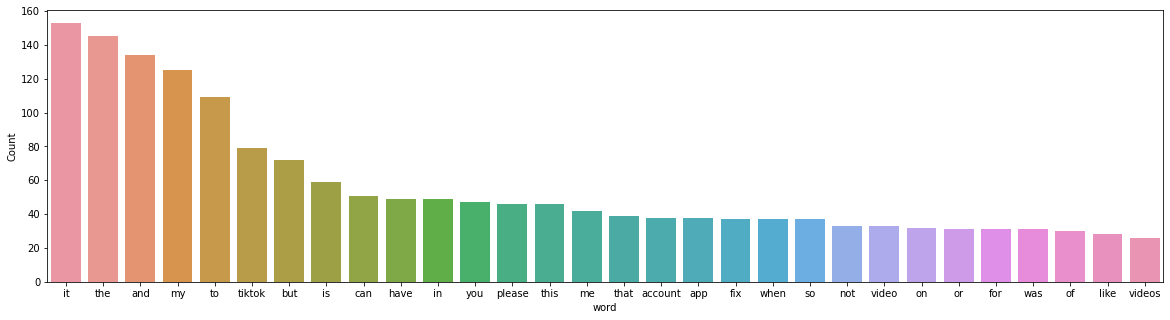

In [126]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2019_score1N2N3))

In [127]:
# Clean text
review_words_ph_ready_2019_score1N2N3 = process_words(review_words_ph_2019_score1N2N3)  # processed Text Data! - move to each section

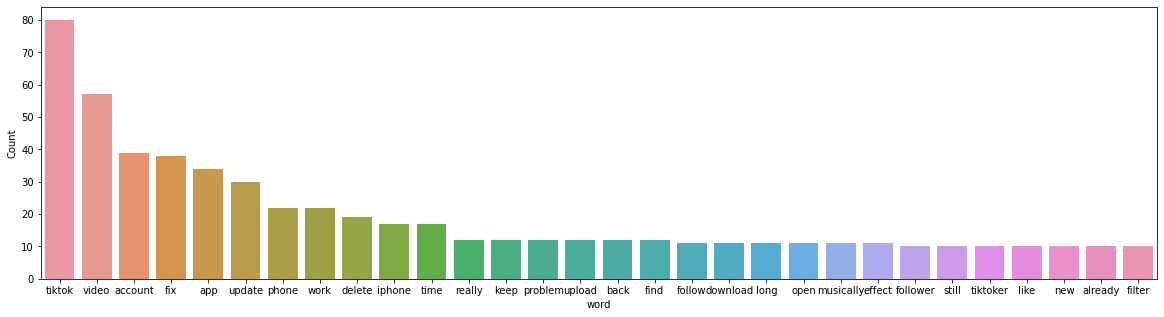

In [128]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2019_score1N2N3))


In [129]:
# Create Dictionary
id2word_ph_2019_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2019_score1N2N3)

In [130]:
# Create Corpus: Term Document Frequency
corpus_ph_2019_score1N2N3 = [id2word_ph_2019_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2019_score1N2N3]

In [131]:
# Training LDA model
model_list_ph_2019_score1N2N3, coherence_values_ph_2019_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2019_score1N2N3, corpus=corpus_ph_2019_score1N2N3, 
                                                              texts=review_words_ph_ready_2019_score1N2N3, limit=30, start=2, step=5)


In [132]:
%store model_list_ph_2019_score1N2N3
%store coherence_values_ph_2019_score1N2N3

Stored 'model_list_ph_2019_score1N2N3' (list)
Stored 'coherence_values_ph_2019_score1N2N3' (list)


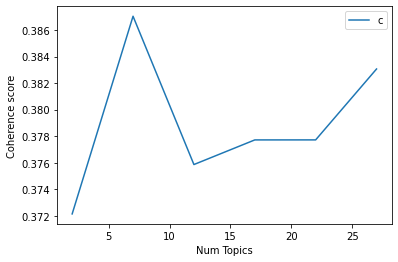

In [133]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2019_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [134]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2019_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 7

index: 0 | Num Topics = 2  has Coherence Value of 0.3721
index: 1 | Num Topics = 7  has Coherence Value of 0.387
index: 2 | Num Topics = 12  has Coherence Value of 0.3759
index: 3 | Num Topics = 17  has Coherence Value of 0.3777
index: 4 | Num Topics = 22  has Coherence Value of 0.3777
index: 5 | Num Topics = 27  has Coherence Value of 0.3831


In [135]:
# Select optimal number of topics
optimal_model_ph_2019_score1N2N3 = model_list_ph_2019_score1N2N3[1]

In [136]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2019_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2019_score1N2N3, corpus_ph_2019_score1N2N3, id2word_ph_2019_score1N2N3)

In [137]:
print("pyLDAVis for ph topics for score=1,2,3 in 2019:")
vis_ph_2019_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2019:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.074176  0.079844       1        1  24.762975
5      0.173707 -0.087251       2        1  16.844827
3     -0.093874 -0.147844       3        1  13.169683
0     -0.052828  0.018043       4        1  12.475151
2     -0.026966  0.091945       5        1  12.049916
1     -0.048481  0.002101       6        1  11.546143
4     -0.025733  0.043161       7        1   9.151306, topic_info=              Term       Freq      Total Category  logprob  loglift
44          tiktok  62.000000  62.000000  Default  30.0000  30.0000
45          update  23.000000  23.000000  Default  29.0000  29.0000
200           work  18.000000  18.000000  Default  28.0000  28.0000
19             app  26.000000  26.000000  Default  27.0000  27.0000
0          account  31.000000  31.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
19             app   0.807777  26.418336   Topic7  -5.1975  -1.0963
194           post   0.784892   6.187082   Topic7  -5.2262   0.3266
34   automatically   0.784883   3.062157   Topic7  -5.2262   1.0299
364            acc   0.784854   2.903469   Topic7  -5.2262   1.0831
386         sister   0.784822   2.271708   Topic7  -5.2263   1.3284

[406 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
364       4  0.344416      acc
364       6  0.344416      acc
364       7  0.344416      acc
147       7  0.695264   access
0         1  0.348091  account
...     ...       ...      ...
170       6  0.370206    wrong
393       5  0.671647       xr
250       3  0.273150     year
250       5  0.546299     year
250       7  0.273150     year

[551 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 4, 1, 3, 2, 5])

## By-rating of 2020 (Rating=1,2,3)

In [138]:
# By-rating Topic Modelling - rating = 1,2,3 in 2020
# Convert to list - move to each section
review_ph_2020_score1N2N3 = tiktok_ios_ph_review_YearMonth_2020_score1N2N3.review.values.tolist()
review_words_ph_2020_score1N2N3 = list(sent_to_words(review_ph_2020_score1N2N3))
print(review_words_ph_2020_score1N2N3[:1])

[['some', 'of', 'my', 'videos', 'don', 'appear', 'to', 'other', 'users', 'even', 'when', 'they', 'look', 'straight', 'at', 'my', 'profile', 'no', 'didn', 'change', 'the', 'privacy', 'setting', 'it', 'just', 'doesn', 'appear', 'already', 'sent', 'feedback', 'in', 'the', 'app', 'itself', 'but', 'didn', 'get', 'any', 'response', 'please', 'fix', 'it', 'it', 'really', 'good', 'and', 'entertaining', 'app', 'and', 'will', 'change', 'my', 'rating', 'once', 'you', 'fix', 'it']]


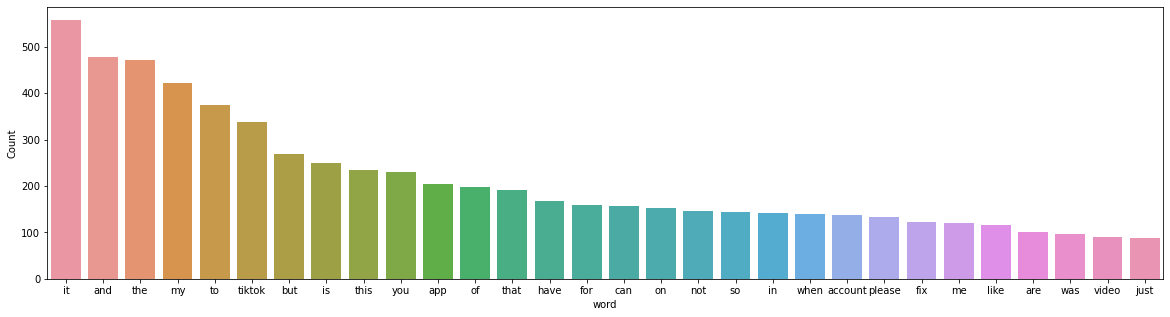

In [139]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2020_score1N2N3))

In [140]:
# Clean text
review_words_ph_ready_2020_score1N2N3 = process_words(review_words_ph_2020_score1N2N3)  # processed Text Data! - move to each section

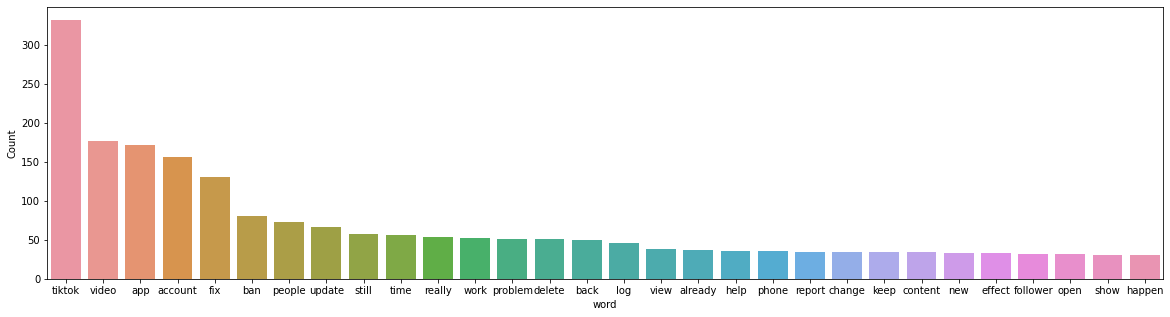

In [141]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2020_score1N2N3))


In [142]:
# Create Dictionary
id2word_ph_2020_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2020_score1N2N3)

In [143]:
# Create Corpus: Term Document Frequency
corpus_ph_2020_score1N2N3 = [id2word_ph_2020_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2020_score1N2N3]

In [144]:
# Training LDA model
model_list_ph_2020_score1N2N3, coherence_values_ph_2020_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2020_score1N2N3, corpus=corpus_ph_2020_score1N2N3, 
                                                              texts=review_words_ph_ready_2020_score1N2N3, limit=30, start=2, step=5)


In [145]:
%store model_list_ph_2020_score1N2N3
%store coherence_values_ph_2020_score1N2N3

Stored 'model_list_ph_2020_score1N2N3' (list)
Stored 'coherence_values_ph_2020_score1N2N3' (list)


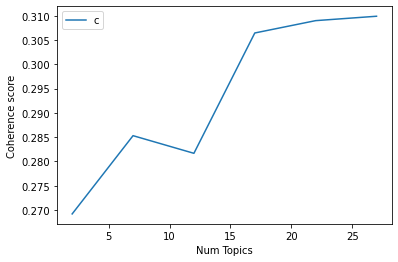

In [146]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2020_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [147]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2020_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.2692
index: 1 | Num Topics = 7  has Coherence Value of 0.2853
index: 2 | Num Topics = 12  has Coherence Value of 0.2817
index: 3 | Num Topics = 17  has Coherence Value of 0.3064
index: 4 | Num Topics = 22  has Coherence Value of 0.309
index: 5 | Num Topics = 27  has Coherence Value of 0.3099


In [187]:
# Select optimal number of topics
optimal_model_ph_2020_score1N2N3 = model_list_ph_2020_score1N2N3[4]

In [188]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2020_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2020_score1N2N3, corpus_ph_2020_score1N2N3, id2word_ph_2020_score1N2N3)

In [189]:
print("pyLDAVis for ph topics for score=1,2,3 in 2020:")
vis_ph_2020_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2020:


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
21     0.048560  0.086438       1        1  8.450190
13     0.052811  0.027876       2        1  8.003723
19     0.071485 -0.019338       3        1  7.460624
15    -0.043697 -0.010089       4        1  7.078767
7      0.016835  0.057832       5        1  5.816214
20     0.050248 -0.046855       6        1  5.169053
3      0.026799  0.089176       7        1  5.154234
14    -0.029805 -0.029065       8        1  5.069194
9      0.018291  0.181922       9        1  5.019164
17     0.075810 -0.017497      10        1  4.946176
5      0.081348  0.044541      11        1  4.930778
2     -0.094909  0.030129      12        1  3.946726
10    -0.072940 -0.066437      13        1  3.676997
8     -0.028213  0.025661      14        1  3.654871
18     0.001354 -0.050078      15        1  3.648276
11     0.049833 -0.133386      16        1  3.062812
1     -0.044108 -0.078364      17        1  2.833147
6      0.115321 -0.067862      18        1  2.797292
16    -0.050194  0.058244      19        1  2.736635
4      0.017957 -0.000164      20        1  2.395020
12    -0.239318  0.006579      21        1  2.356808
0     -0.023470 -0.089262      22        1  1.793300, topic_info=         Term        Freq       Total Category  logprob  loglift
175      view   30.000000   30.000000  Default  30.0000  30.0000
105   account  132.000000  132.000000  Default  29.0000  29.0000
48        log   39.000000   39.000000  Default  28.0000  28.0000
6         fix  110.000000  110.000000  Default  27.0000  27.0000
21   follower   27.000000   27.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
9     profile    0.770273   21.224997  Topic22  -4.9457   0.7049
0     already    0.743907   31.789434  Topic22  -4.9806   0.2661
53      still    0.743904   49.313294  Topic22  -4.9806  -0.1729
250     great    0.743904   14.013426  Topic22  -4.9806   1.0853
248      feel    0.743904    8.013561  Topic22  -4.9806   1.6441

[1349 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
216      10  0.599936    abd
412       1  0.496354   able
412       3  0.165451   able
412       4  0.165451   able
412      12  0.165451   able
...     ...       ...    ...
1095     11  0.154457  young
1095     14  0.154457  young
1095     16  0.617827  young
543      11  0.795910     yt
298      15  0.613651   zoom

[2374 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[22, 14, 20, 16, 8, 21, 4, 15, 10, 18, 6, 3, 11, 9, 19, 12, 2, 7, 17, 5, 13, 1])

## By-rating of 2021 (Rating=1,2,3)

In [151]:
# By-rating Topic Modelling - rating = 1,2,3 in 2021
# Convert to list - move to each section
review_ph_2021_score1N2N3 = tiktok_ios_ph_review_YearMonth_2021_score1N2N3.review.values.tolist()
review_words_ph_2021_score1N2N3 = list(sent_to_words(review_ph_2021_score1N2N3))
print(review_words_ph_2021_score1N2N3[:1])

[['have', 'tiktok', 'account', 'since', 'and', 'just', 'yesterday', 'it', 'got', 'permanently', 'banned', 'even', 'tho', 'didnt', 'do', 'anything', 'wrong', 'against', 'the', 'community', 'guidelines', 'please', 'help', 'my', 'account', 'get', 'back']]


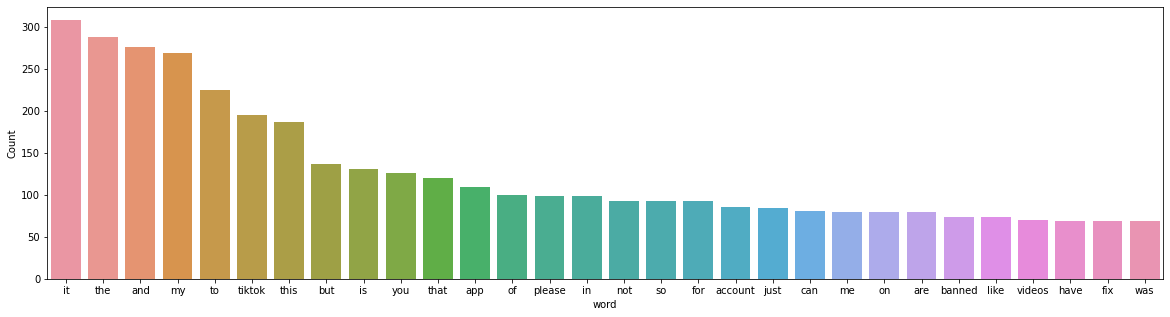

In [152]:
# Inspect the frequency of words before cleaning
freq_words(flatten(review_words_ph_2021_score1N2N3))

In [153]:
# Clean text
review_words_ph_ready_2021_score1N2N3 = process_words(review_words_ph_2021_score1N2N3)  # processed Text Data! - move to each section

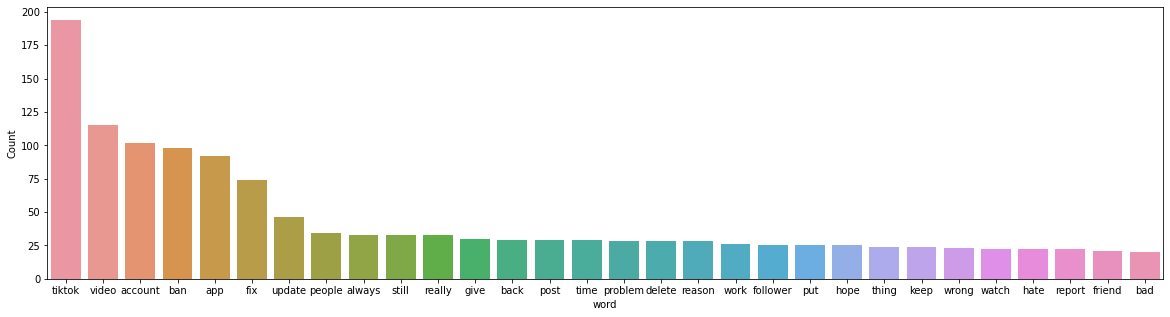

In [154]:
# Inspect the frequency of words after cleaning
freq_words(flatten(review_words_ph_ready_2021_score1N2N3))


In [155]:
# Create Dictionary
id2word_ph_2021_score1N2N3 = corpora.Dictionary(review_words_ph_ready_2021_score1N2N3)

In [156]:
# Create Corpus: Term Document Frequency
corpus_ph_2021_score1N2N3 = [id2word_ph_2021_score1N2N3.doc2bow(text) for text in review_words_ph_ready_2021_score1N2N3]

In [157]:
# Training LDA model
model_list_ph_2021_score1N2N3, coherence_values_ph_2021_score1N2N3 = compute_coherence_values(dictionary=id2word_ph_2021_score1N2N3, corpus=corpus_ph_2021_score1N2N3, 
                                                              texts=review_words_ph_ready_2021_score1N2N3, limit=30, start=2, step=5)


In [158]:
%store model_list_ph_2021_score1N2N3
%store coherence_values_ph_2021_score1N2N3

Stored 'model_list_ph_2021_score1N2N3' (list)
Stored 'coherence_values_ph_2021_score1N2N3' (list)


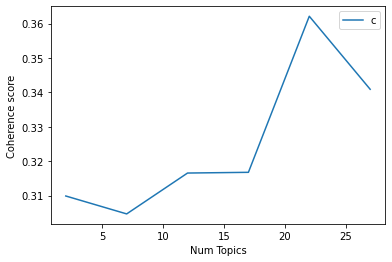

In [159]:
# Plot to see coherence score in order to choose optimal number of topics and decide optimal model
limit=30; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values_ph_2021_score1N2N3)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [160]:
# Print the coherence scores
index = 0
for m, cv in zip(x, coherence_values_ph_2021_score1N2N3):
    print("index:",index,"|","Num Topics =", m, " has Coherence Value of", round(cv, 4))
    index = index + 1

# optimal num_topics = 22

index: 0 | Num Topics = 2  has Coherence Value of 0.3099
index: 1 | Num Topics = 7  has Coherence Value of 0.3046
index: 2 | Num Topics = 12  has Coherence Value of 0.3165
index: 3 | Num Topics = 17  has Coherence Value of 0.3167
index: 4 | Num Topics = 22  has Coherence Value of 0.3621
index: 5 | Num Topics = 27  has Coherence Value of 0.3409


In [190]:
# Select optimal number of topics
optimal_model_ph_2021_score1N2N3 = model_list_ph_2021_score1N2N3[4]

In [191]:
# pyLDAVis
pyLDAvis.enable_notebook()
vis_ph_2021_score1N2N3 = pyLDAvis.gensim_models.prepare(optimal_model_ph_2021_score1N2N3, corpus_ph_2021_score1N2N3, id2word_ph_2021_score1N2N3)

In [192]:
print("pyLDAVis for ph topics for score=1,2,3 in 2021:")
vis_ph_2021_score1N2N3

pyLDAVis for ph topics for score=1,2,3 in 2021:


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
13    -0.032461  0.105062       1        1  10.070625
9     -0.085023  0.117985       2        1   9.068932
7     -0.141045  0.010174       3        1   8.010695
1     -0.174488 -0.059844       4        1   8.000451
11    -0.082864  0.055318       5        1   7.695063
20    -0.071156 -0.036526       6        1   7.410739
16    -0.039610  0.100371       7        1   5.048874
0     -0.031298 -0.046769       8        1   5.026969
12    -0.026211  0.023397       9        1   4.815393
19     0.162985  0.135916      10        1   4.633011
5     -0.011474  0.102729      11        1   4.582743
14    -0.024368 -0.075758      12        1   4.248472
8     -0.001556 -0.045318      13        1   3.841146
17     0.101655  0.035565      14        1   3.380799
4      0.106309 -0.003445      15        1   3.343218
21     0.034685 -0.011805      16        1   2.349253
18     0.056844 -0.060184      17        1   2.216828
10    -0.011704 -0.086204      18        1   1.653503
2      0.001961 -0.080312      19        1   1.519300
3      0.115324  0.016763      20        1   1.516409
15     0.091556 -0.112743      21        1   1.010975
6      0.061940 -0.084373      22        1   0.556603, topic_info=        Term        Freq       Total Category  logprob  loglift
0    account   87.000000   87.000000  Default  30.0000  30.0000
2        ban   82.000000   82.000000  Default  29.0000  29.0000
16       fix   61.000000   61.000000  Default  28.0000  28.0000
8     tiktok  161.000000  161.000000  Default  27.0000  27.0000
227   report   18.000000   18.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
927      pay    0.017159    1.616077  Topic22  -7.1639   0.6458
195     less    0.017159    3.217601  Topic22  -7.1639  -0.0428
648     warn    0.017159    3.353403  Topic22  -7.1639  -0.0841
683   access    0.017159    3.825333  Topic22  -7.1639  -0.2158
929    refer    0.017159    1.616077  Topic22  -7.1639   0.6458

[1218 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
417      12  0.657805   ability
353       7  0.263988      able
353       8  0.527976      able
353      19  0.263988      able
986       3  0.629359  absolute
...     ...       ...       ...
536      13  0.338457       yet
536      18  0.169229       yet
536      21  0.169229       yet
202       5  0.909626  youtuber
806       6  0.625268     yrold

[1879 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 10, 8, 2, 12, 21, 17, 1, 13, 20, 6, 15, 9, 18, 5, 22, 19, 11, 3, 4, 16, 7])

# Export pyLDAvis as html

In [203]:
# Overall
pyLDAvis.save_html(vis_ph,'tiktok_vis_ph.html')

# By-rating 
pyLDAvis.save_html(vis_ph_score1,'tiktok_vis_ph_score1.html')
pyLDAvis.save_html(vis_ph_score2,'tiktok_vis_ph_score2.html')
pyLDAvis.save_html(vis_ph_score3,'tiktok_vis_ph_score3.html')
pyLDAvis.save_html(vis_ph_score4,'tiktok_vis_ph_score4.html')
pyLDAvis.save_html(vis_ph_score5,'tiktok_vis_ph_score5.html')
pyLDAvis.save_html(vis_ph_score1N2N3,'tiktok_vis_ph_score1N2N3.html')

# By-rating of each year
pyLDAvis.save_html(vis_ph_2021_score1N2N3,'tiktok_vis_ph_2021_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2020_score1N2N3,'tiktok_vis_ph_2020_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2019_score1N2N3,'tiktok_vis_ph_2019_score1N2N3.html')
pyLDAvis.save_html(vis_ph_2018_score1N2N3,'tiktok_vis_ph_2018_score1N2N3.html')

